In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd

sys.path.insert(1, '/scr/gmachi/prospection/K2/src')
from utils import deserialize, serialize, deserialize_model

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from sklearn.preprocessing import MinMaxScaler

# Collecting info on all cells
- this portion of code could require high-memory CPU machines. I generally used up to 50+ GB RAM

In [4]:
# feats_dict = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/raw_sample.obj")

In [5]:
# print(list(feats_dict.keys())[0])
# print(len(feats_dict.keys()))

## K-means on marker expression alone
- we are curious how expression alone clusters. Let's sample the same cells used for layer I in prospector heads

In [6]:
# from sklearn.cluster import KMeans

# X = np.array(list(feats_dict.values()))
# print(X.shape)
# kmeans = KMeans(n_clusters=12, random_state=0, n_init="auto").fit(X)

In [7]:
# serialize(kmeans, "/scr/biggest/gmachi/datasets/celldive_lung/kmeans_on_raw_final.obj")

## Now label all cells in all graphs by this k-means model
do this for all data + class-1 on salient dataset

In [8]:
import networkx as nx

In [9]:
G_dir1 = "/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect_final"
save_dir1 = "/scr/biggest/gmachi/datasets/celldive_lung/clustered_only_final"

In [10]:
# for i,G in enumerate(os.listdir(G_dir1)):
#     G_file = G.split(".")[0] + "_with_clusters.obj"
    
#     G_path = os.path.join(G_dir1, G)
#     G = deserialize(G_path)
    
#     G_new = G.copy()
#     raw_dict = nx.get_node_attributes(G_new, "raw")
#     node_ids = list(raw_dict.keys())
#     G_feats = np.array(list(raw_dict.values()))
#     G_clusters = kmeans.predict(G_feats)
#     cluster_dict = dict(zip(node_ids, G_clusters))
    
#     nx.set_node_attributes(G_new, cluster_dict, "exp_cluster")
#     save_path = os.path.join(save_dir1, G_file)
#     serialize(G_new, save_path)
    
#     if i % 20 == 0:
#         print("completed", i)

In [11]:
G_dir2 = "/scr/biggest/gmachi/datasets/celldive_lung/prospected_final/k12r5fc_concept_overlay"
#"/scr/biggest/gmachi/datasets/celldive_lung/prospected/k9r3fc_concept_overlay"
save_dir2 = "/scr/biggest/gmachi/datasets/celldive_lung/prospected_final/k12r5fc_concept_cluster"
#"/scr/biggest/gmachi/datasets/celldive_lung/prospected/k9r3fc_concept_cluster"

In [12]:
# for i,G in enumerate(os.listdir(G_dir2)):
#     G_file = G.split(".")[0] + "_with_clusters.obj"
    
#     G_path = os.path.join(G_dir2, G)
#     G = deserialize(G_path)
    
#     G_new = G.copy()
#     raw_dict = nx.get_node_attributes(G_new, "raw")
#     node_ids = list(raw_dict.keys())
#     G_feats = np.array(list(raw_dict.values()))
#     G_clusters = kmeans.predict(G_feats)
#     cluster_dict = dict(zip(node_ids, G_clusters))
    
#     nx.set_node_attributes(G_new, cluster_dict, "exp_cluster")
#     save_path = os.path.join(save_dir2, G_file)
#     serialize(G_new, save_path)
    
#     if i % 20 == 0:
#         print("completed", i)

we use the above graphs for spatial analysis. we use dataframes as our ridgeline plotting source

# Create a master dataframe to do cell-level analysis!

In [13]:
label_path = "/scr/biggest/gmachi/datasets/celldive_lung/processed/label_dict.obj"
label_dict = deserialize(label_path)

In [14]:
from test_signal import graph2df

In [15]:
# G_dir = "/scr/biggest/gmachi/datasets/celldive_lung/prospected_final/k12r5fc_concept_overlay"
# cell_dfs = []

# for i,G in enumerate(os.listdir(G_dir)):
#     G_id = int(G.split("_")[0].split("S")[1])
#     if label_dict[G_id] == 1:
#         G_path = os.path.join(G_dir, G)
#         G = deserialize(G_path)
        
#         dfG = graph2df(G, ["cell_id", "cell_type", "concept", "salient", "emb", "raw"])
#         dfG["salbin"] = np.where(np.isnan(dfG['salient']), "non-salient", "salient")
#         cell_dfs.append(dfG)

# dfGs = pd.concat(cell_dfs, ignore_index=True)

In [16]:
# dfGs["class_member"] = 1

In [17]:
# dfGs.shape

Shape is (613059, 9)

In [18]:
# serialize(dfGs, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_1.df")
# dfGs.to_csv("/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_1.csv", chunksize=10000)

currently missing concept/group labels for class-0

In [19]:
# from utils import deserialize, deserialize_model
# proc_path = "/scr/gmachi/prospection/K2/notebooks/spatial-bio/outputs/gridsearch_results_final/k2processors/k12.processor"
# proc = deserialize_model(proc_path)

In [20]:
# from utils import construct_sprite
# G_dir = "/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect_final"
# cell_dfs_0 = []

# for i,G in enumerate(os.listdir(G_dir)):
#     G_id = int(G.split(".")[0].split("S")[1])
#     if label_dict[G_id] == 0:
#         G_path = os.path.join(G_dir, G)
#         G = deserialize(G_path)
#         S = construct_sprite(G, proc, key_in="emb", key_out="concept")
        
#         dfG = graph2df(S, ["cell_id", "cell_type", "concept", "emb", "raw"])
#         cell_dfs_0.append(dfG)

# dfGs_0 = pd.concat(cell_dfs_0, ignore_index=True)

In [21]:
# serialize(dfGs_0, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_0.df")
# dfGs_0.to_csv("/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_0.csv", chunksize=10000)

In [22]:
# dfGs_0.shape

In [23]:
# dfGs_0["salient"] = np.nan
# dfGs_0["class_member"] = 0
# dfGs_0["salbin"] = "non-salient"
# print(dfGs_0.shape)

Shape is (762207, 9)

# Concat both dfs

In [24]:
# dfGs = pd.read_csv("/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_1.csv")
# print(dfGs.shape)
# dfGs_0 = pd.read_csv("/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_0.csv")
# print(dfGs_0.shape)

(613059, 10)
(762207, 7)


In [25]:
# dfGs_0["salient"] = np.nan
# dfGs_0["class_member"] = 0
# dfGs_0["salbin"] = "non-salient"
# print(dfGs_0.shape)

(762207, 10)


In [28]:
# dfGs_all = pd.concat([dfGs, dfGs_0], ignore_index=True)
# dfGs_all.shape

(1375266, 10)

In [21]:
# serialize(dfGs_all, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_all.df")
# dfGs_all.to_csv("/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_all.csv", chunksize=10000)

In [22]:
# dfGs_all.shape

## now we take a look at clusters' marker distributions
- we use riddgeline plots as we do for concepts

In [23]:
import pandas as pd
dfGs_all = pd.read_csv("/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/dfGs_all.csv")

In [24]:
dfGs_all.shape

(1375266, 11)

In [25]:
dfGs_all.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'node', 'cell_id', 'cell_type', 'concept',
       'salient', 'emb', 'raw', 'salbin', 'class_member'],
      dtype='object')

In [26]:
def parse_df_list(row):
    row = row.split(" ")
    row = [r.strip() for r in row]
    row = [r.rstrip("]") for r in row]
    row = [r.lstrip("[]") for r in row]
    row = [float(r) for r in row if r not in ["[", "", "]"]]     
    return row

we first assign cluster IDs to all cells

In [27]:
kmeans = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/kmeans_on_raw_final.obj")

In [28]:
X = dfGs_all.loc[:, "raw"]
X = X.apply(lambda x: parse_df_list(x))
X = np.vstack(list(X.values))
dfGs_all["exp_cluster"] = kmeans.predict(X)

In [29]:
dfGs_all.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'node', 'cell_id', 'cell_type', 'concept',
       'salient', 'emb', 'raw', 'salbin', 'class_member', 'exp_cluster'],
      dtype='object')

In [30]:
G_ex = deserialize("/scr/biggest/gmachi/datasets/celldive_lung/for_ml/for_prospect_final/S3.obj")
prot_feats = list(G_ex.nodes[0]["biomarker_expression"].keys())
morph_feats = ['AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']
all_feats = prot_feats + morph_feats
print(all_feats)

['AKT', 'AMPHIREGULIN', 'BETA_CATENIN', 'BETA_TUBULIN', 'CA9', 'CK5', 'CK7', 'CMET', 'CYCLIN_B', 'ECAD', 'EGFR', 'EGFR_PY1068', 'ERK', 'ERK1_2_PT202_PY204', 'HER2', 'IGF1R', 'NAKATPASE', 'P21', 'P4EBP1', 'PANKERATIN', 'PGSK3BETA', 'PHISTONEH3', 'PHOSPHOTYROSINE', 'PTEN', 'RRM1', 'S6', 'STAT3', 'STAT3_PY705', 'VGFR2', 'AREA_CELL', 'ECCENTRICITY', 'MAJORAXISLENGTH', 'MINORAXISLENGTH', 'PERIMETER']


In [31]:
feat2idx_dict = {feat: i for i,feat in enumerate(all_feats)}

## Do some quick differences between some features

In [32]:
X_nonsal = dfGs_all[dfGs_all["salbin"] == "non-salient"]["raw"].apply(lambda x: parse_df_list(x))
X_nonsal = np.vstack(list(X_nonsal.values))
X_nonsal

array([[ 11.06986137,   9.43431884,   6.23159847, ...,  19.        ,
          8.298     ,  53.        ],
       [ 10.86945364,  10.11149771,   0.        , ...,  26.861     ,
         17.553     ,  88.        ],
       [ 11.37024529,  10.14242957,   0.        , ...,  15.787     ,
          7.649     ,  44.        ],
       ...,
       [  8.96297771,  10.4202079 ,   8.45550555, ...,  55.981     ,
         31.846     , 196.        ],
       [  9.11771859,  10.32156259,   8.38763752, ...,  33.004     ,
         21.765     , 117.        ],
       [  8.88231951,  10.3481774 ,   8.29331306, ...,  67.692     ,
         34.406     , 227.        ]])

In [33]:
X_sal = dfGs_all[dfGs_all["salbin"] == "salient"]["raw"].apply(lambda x: parse_df_list(x))
X_sal = np.vstack(list(X_sal.values))
X_sal

array([[10.40084193, 10.96222159,  0.        , ..., 16.978     ,
        14.958     , 68.        ],
       [10.2718136 , 10.53599554,  7.21888741, ..., 17.404     ,
        10.959     , 52.        ],
       [ 9.60363972,  8.96593191,  0.        , ..., 12.823     ,
         6.486     , 36.        ],
       ...,
       [ 9.3542862 , 10.82909354,  6.11726296, ..., 16.323     ,
         9.698     , 54.        ],
       [ 9.06431621, 11.00993287,  7.24279385, ..., 19.908     ,
        18.443     , 88.        ],
       [ 0.        , 11.81736954,  6.88022377, ..., 11.99      ,
         7.793     , 36.        ]])

In [34]:
diffs = []
feats_focus = all_feats#["PANKERATIN", "CK5", "PHOSPHOTYROSINE", "P4EBP1", "CK7", "P21"]
for feat in feats_focus:
    diff = np.std(X_sal[:, feat2idx_dict[feat]]) - np.std(X_nonsal[:, feat2idx_dict[feat]])
    diffs.append(diff)

<BarContainer object of 34 artists>

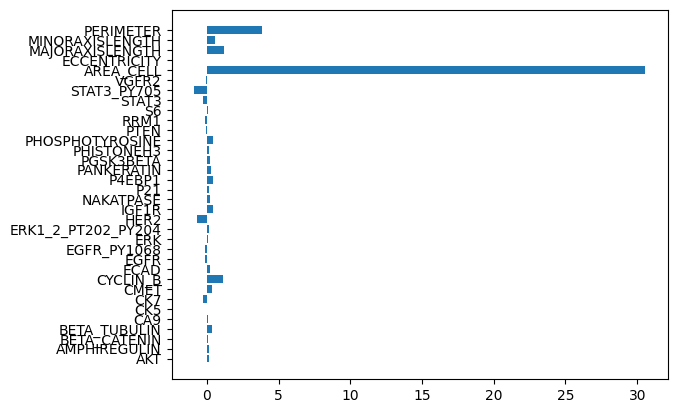

In [35]:
plt.figure()
plt.barh(feats_focus, diffs)

## Now we do ridgelines!

In [36]:
CMAP2 = "Pastel2"
joint_cmap = colors.ListedColormap(cm.tab20.colors + cm.Pastel2.colors, name='tab40')
joint_cmap.set_bad(color='lightgray') #used to be white

In [37]:
def filter_data(key, value, df):
    subset = df[df[key] == value]
    return subset

def filter_data_2conds(key_a, value_a, key_b, value_b, df):
    subset = df[(df[key_a] == value_a) & (df[key_b] == value_b)]
    return subset

def plot_ridgeline(key, value, df, feat_names, feat2idx_dict=None, cond_count=1):
    if key == "cluster":
        search_key = "exp_cluster"
    else:
        search_key = key
    
    if len(feat_names) < 34 and feat2idx_dict is not None:
        idxs = [feat2idx_dict[feat] for feat in feat_names]
        
    X_all = df.loc[:, "raw"]
    X_all = X_all.apply(lambda x: parse_df_list(x))
    X_all = np.vstack(list(X_all.values))
    scaler = MinMaxScaler()
    scaler.fit(X_all)
    
    if cond_count == 1:
        subset = filter_data(search_key, value, df)
    elif cond_count == 2:
        subset = filter_data_2conds(search_key, value, "salbin", "salient", df)
    else:
        print("Error: only 1 or 2 conditions are supported.")
        exit()
        
    X = subset.loc[:, "raw"]
    X = X.apply(lambda x: parse_df_list(x))
    X = np.vstack(list(X.values))
    X = scaler.transform(X)
    p = X.shape[1]
    
    plt.figure()
    if len(feat_names) < 34 and feat2idx_dict is not None:
        print("Note: only using a subset of features as requested...")
        X = X[:, idxs]
        p = X.shape[1]
        fig, ax = plt.subplots(figsize=(2, 4))
        w = 1.5
    else: 
        fig, ax = plt.subplots(figsize=(3, 12))
        w = 1
    
    ax.yaxis.grid(True, linestyle='-')        

    parts = ax.violinplot(X, positions=np.arange(p), widths=w, vert=False, showmeans=True, showmedians=False, showextrema=False, side="high")
    
    if key == "concept":
        c = joint_cmap(value)
    else:
        c = "brown"
        
    for pc in parts['bodies']:
        pc.set_facecolor(c)
        # pc.set_edgecolor('black')
        pc.set_alpha(0.8)
    parts['cmeans'].set_colors("k")
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    if key == "cluster":
        title_str = key.title() + " "
    elif key == "concept":
        title_str = "Group "
    
    ax.set_title(title_str + str(value))
    #'Rescaled marker\ndistributions for ' +
    ax.set_yticks(np.arange(p), feat_names, rotation=0)
    ax.set_xlim(-0.05, 1.05)
    plt.show()
    return

In [142]:
def get_medians(key, value, df, feat_names, feat2idx_dict=None, cond_count=1):
    if key == "cluster":
        search_key = "exp_cluster"
    else:
        search_key = key
    
    if len(feat_names) < 34 and feat2idx_dict is not None:
        idxs = [feat2idx_dict[feat] for feat in feat_names]
        
    X_all = df.loc[:, "raw"]
    X_all = X_all.apply(lambda x: parse_df_list(x))
    X_all = np.vstack(list(X_all.values))
    scaler = MinMaxScaler()
    scaler.fit(X_all)
    
    if cond_count == 1:
        subset = filter_data(search_key, value, df)
    elif cond_count == 2:
        subset = filter_data_2conds(search_key, value, "salbin", "salient", df)
    else:
        print("Error: only 1 or 2 conditions are supported.")
        exit()
        
    X = subset.loc[:, "raw"]
    X = X.apply(lambda x: parse_df_list(x))
    X = np.vstack(list(X.values))
    X = scaler.transform(X)
    p = X.shape[1]
    
    if len(feat_names) < 34 and feat2idx_dict is not None:
        X = X[:, idxs]
        p = X.shape[1]
    
    medians = np.median(X, axis=0)
    print(medians.shape)
    return medians

the below list is iterated on by using fold-changes acquired further down the notebook

In [143]:
# feat_subset = ['CK7', 'PANKERATIN', 'PHISTONEH3', 'AREA_CELL']
# feat_subset = ['BETA_TUBULIN','CK5','CK7','P21','PANKERATIN','PHISTONEH3','AREA_CELL','MAJORAXISLENGTH']
feat_subset_raw = ['BETA_CATENIN', 'CK7', 'P21', 'PHISTONEH3', 'PHOSPHOTYROSINE', 'AREA_CELL']
feat_subset_sal = ['BETA_CATENIN','BETA_TUBULIN','CK7', 'P21', 'P4EBP1', 'PHISTONEH3', 'PHOSPHOTYROSINE','AREA_CELL']
feat_subset = ['BETA_CATENIN','BETA_TUBULIN', 'CK7', 'P21', 'P4EBP1', 'PHISTONEH3', 'PHOSPHOTYROSINE', 'AREA_CELL'] 


In [144]:
meds_array = []
for i in range(12):
    meds = get_medians("concept", i, dfGs_all, feat_subset, feat2idx_dict)
    meds_array.append(meds)

(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)


In [181]:
serialize(meds_array, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/meds_array_concept.df")

In [188]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
CMAP2 = "Pastel2"
joint_cmap = colors.ListedColormap(cm.tab20.colors + cm.Pastel2.colors, name='tab40')
joint_cmap.set_bad(color='lightgray') #used to be white


def rand_jitter(arr):
    stdev = 0.1 #0.004 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def cleveland(species_stat, species):
    plt.figure()
    fig, ax = plt.subplots(figsize=(3, 6))
    ax.yaxis.grid(True, linestyle='-')
    i = 0
    for ss in species_stat:
        rects = ax.scatter(ss, rand_jitter(np.arange(len(species))), label=species, s=80, alpha=0.6, marker="o", color=joint_cmap(i))
        i += 1

    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('Median Protein Expression\nby Cell Group')
    ax.set_yticks(np.arange(len(species)), species, rotation=0)
    ax.set_xlim(-0.05, 1)
    # ax.legend(bbox_to_anchor=(1.05, -0.03))
    plt.show()

<Figure size 640x480 with 0 Axes>

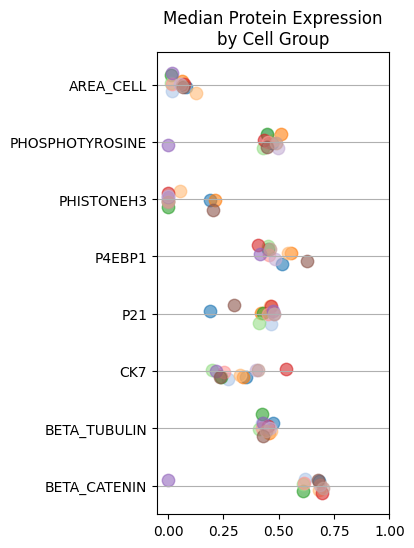

In [189]:
cleveland(meds_array, feat_subset)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

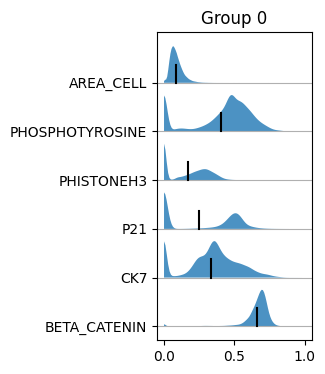

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

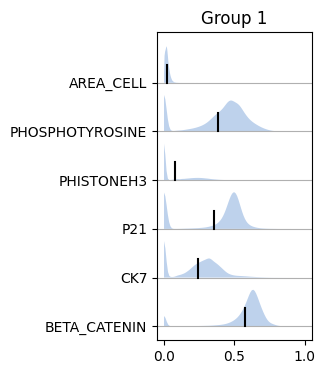

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

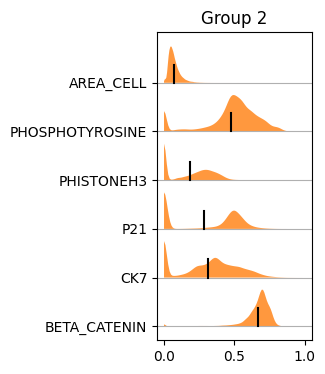

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

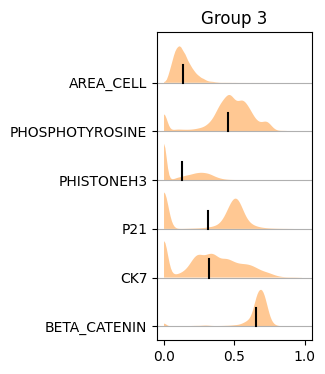

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

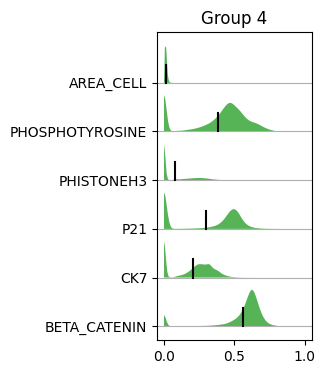

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

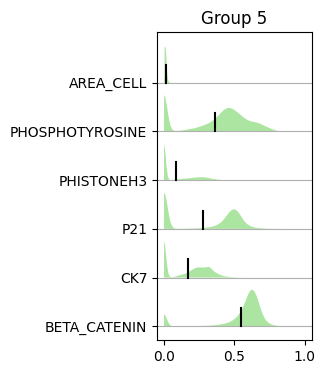

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

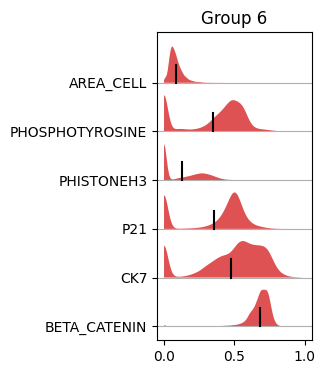

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

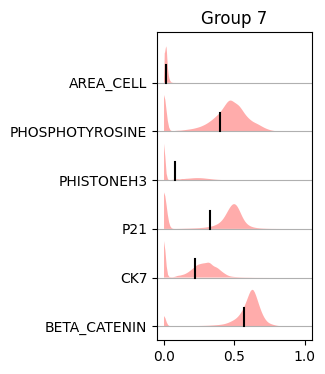

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

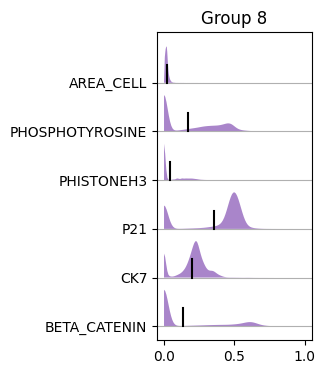

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

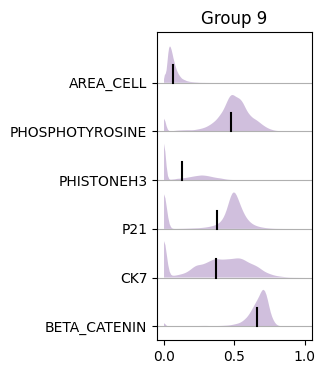

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

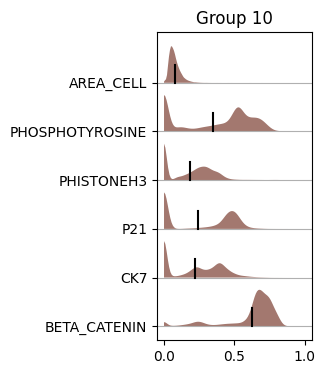

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

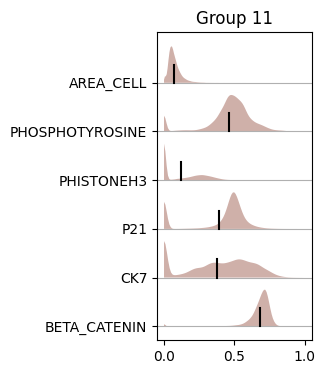

In [135]:
# plot_ridgeline("concept", 0, dfGs_all, all_feats)
for i in range(12):
    plot_ridgeline("concept", i, dfGs_all, feat_subset, feat2idx_dict)
    break

In [40]:
# plot_ridgeline("concept", 1, dfGs_all, all_feats)
# plot_ridgeline("concept", 1, dfGs_all, feat_subset, feat2idx_dict)

In [41]:
# plot_ridgeline("concept", 3, dfGs_all, all_feats)
# plot_ridgeline("concept", 3, dfGs_all, feat_subset, feat2idx_dict)

In [42]:
# plot_ridgeline("concept", 6, dfGs_all, all_feats)
# plot_ridgeline("concept", 6, dfGs_all, feat_subset, feat2idx_dict)

In [43]:
# plot_ridgeline("concept", 8, dfGs_all, all_feats)
# plot_ridgeline("concept", 8, dfGs_all, feat_subset, feat2idx_dict)

other concepts

In [44]:
# plot_ridgeline("concept", 2, dfGs_all, all_feats)
# plot_ridgeline("concept", 2, dfGs_all, feat_subset, feat2idx_dict)

In [45]:
# plot_ridgeline("concept", 4, dfGs_all, all_feats)
# plot_ridgeline("concept", 4, dfGs_all, feat_subset, feat2idx_dict)

In [46]:
# plot_ridgeline("concept", 5, dfGs_all, all_feats)
# plot_ridgeline("concept", 5, dfGs_all, feat_subset, feat2idx_dict)

In [47]:
# plot_ridgeline("concept", 7, dfGs_all, all_feats)
# plot_ridgeline("concept", 7, dfGs_all, feat_subset, feat2idx_dict)

## let's also do the clusters

In [179]:
meds_array_cluster = []
for i in range(12):
    meds = get_medians("cluster", i, dfGs_all, feat_subset, feat2idx_dict)
    meds_array_cluster.append(meds)

(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)
(8,)


In [180]:
serialize(meds_array_cluster, "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/meds_array_cluster.df")

In [192]:
def rand_jitter(arr):
    stdev = 0.1 #0.004 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def cleveland(species_stat, species):
    plt.figure()
    fig, ax = plt.subplots(figsize=(3, 6))
    ax.yaxis.grid(True, linestyle='-')
    i = 0
    for ss in species_stat:
        rects = ax.scatter(ss, rand_jitter(np.arange(len(species))), label=species, s=80, alpha=0.6, marker="o", color="brown")
        i += 1

    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title('Median Protein Expression\nby Cell Cluster')
    ax.set_yticks(np.arange(len(species)), species, rotation=0)
    ax.set_xlim(-0.05, 1)
    # ax.legend(bbox_to_anchor=(1.05, -0.03))
    plt.show()

<Figure size 640x480 with 0 Axes>

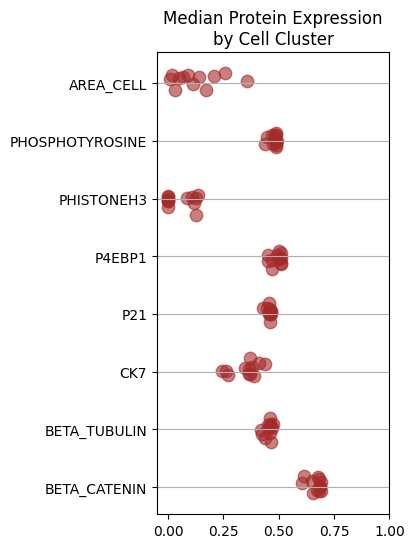

In [193]:
cleveland(meds_array_cluster, feat_subset)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

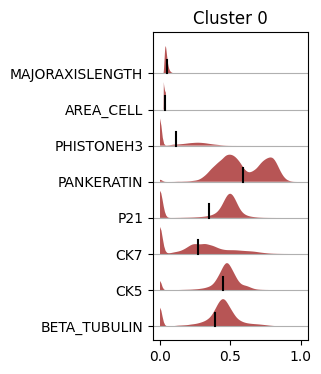

In [48]:
# plot_ridgeline("cluster", 0, dfGs_all, all_feats)
for i in range(12):
    plot_ridgeline("cluster", i, dfGs_all, feat_subset, feat2idx_dict)
    break

In [61]:
# plot_ridgeline("cluster", 1, dfGs_all, all_feats)
# plot_ridgeline("cluster", 1, dfGs_all, feat_subset, feat2idx_dict)

In [62]:
# for i in range(2,9):
#     plot_ridgeline("cluster", i, dfGs_all, feat_subset, feat2idx_dict)
    # plot_ridgeline("cluster", i, dfGs_all, all_feats)

## Now lets get distances from clusters and concepts

In [49]:
from scipy import stats
from scipy.spatial import distance
import ipdb

In [50]:
def diff_exp(X0, X1):
    mu0 = X0.mean(axis=0)    
    mu1 = X1.mean(axis=0)
    fc = np.log2(mu1 / mu0)
    pval = stats.ttest_ind(X1, X0)[1]
    pval_adj = pval * len(pval)
    pval_sig = pval_adj < 0.01
    res = [(i, fc[i], np.abs(fc[i]), pval_sig[i]) for i in range(len(fc)) if pval_sig[i] == True]
    res.sort(key=lambda x: x[2], reverse=True)
    return res[0]

def cos_dist(X0, X1):
    mu0 = X0.mean(axis=0)    
    mu1 = X1.mean(axis=0)
    return distance.cosine(mu0, mu1)
    
def compute_differences(key0, val0, key1, val1, df, mode="diff_exp"):
    if key0 == "cluster":
        search_key0 = "exp_cluster"
    else:
        search_key0 = key0
    if key1 == "cluster":
        search_key1 = "exp_cluster"
    else:
        search_key1 = key1
    
    subset0 = filter_data(search_key0, val0, df)
    subset1 = filter_data(search_key1, val1, df)
    
    X0 = subset0.loc[:, "raw"]
    X0 = X0.apply(lambda x: parse_df_list(x))
    X0 = np.vstack(list(X0.values))
    
    X1 = subset1.loc[:, "raw"]
    X1 = X1.apply(lambda x: parse_df_list(x))
    X1 = np.vstack(list(X1.values))
    
    if mode == "diff_exp":
        res = diff_exp(X0, X1)
    elif mode == "cos_dist":
        res = cos_dist(X0, X1)
    return res
    

def difference_runner(df, mode="diff_exp"):
    res_dict = {}
    for key0 in ["concept", "cluster"]:
        for val0 in range(12):
            for key1 in ["concept", "cluster"]:
                for val1 in range(12):
                    if key0 == key1 and val0 == val1:
                        continue
                    if (key0, val0, key1, val1) in res_dict.keys():
                        continue
                    if (key1, val1, key0, val0) in res_dict.keys():
                        continue
                    else:
                        print(key0, val0, key1, val1)
                        res = compute_differences(key0, val0, key1, val1, df, mode=mode)
                        res_dict[(key0, val0, key1, val1)] = res
    return res_dict
    

In [51]:
# res_dict_diffexp = difference_runner(dfGs_all, mode="diff_exp")

In [52]:
res_save_path = "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/res_dict_de.obj"
# serialize(res_dict_diffexp, res_save_path)

In [53]:
res_dict_diffexp  = deserialize(res_save_path)

In [54]:
list(res_dict_diffexp.values())[0]

(29, -1.8337567256718814, 1.8337567256718814, True)

 now do cosine distances

In [55]:
# res_dict_cosine = difference_runner(dfGs_all, mode="cos_dist")

In [194]:
res_save_path = "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/res_dict_cd.obj"
# serialize(res_dict_cosine, res_save_path)

In [195]:
res_dict_cosine  = deserialize(res_save_path)

Note: ran til here!

In [196]:
comparisons = []
for el in ["concept", "cluster"]:
    for i in range(12):
        comparisons.append(el + " " + str(i))

In [197]:
N = len(comparisons)

In [198]:
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0, val0 = comparisons[i].split(" ")
        key1, val1 = comparisons[j].split(" ")
        val0, val1 = int(val0), int(val1)
        if key0 == key1 and val0 == val1:
            res_arr[i,j] = 0
        if (key0, val0, key1, val1) in res_dict_cosine.keys():
            res = res_dict_cosine[(key0, val0, key1, val1)]
            res_arr[i,j] = res

(24, 24)


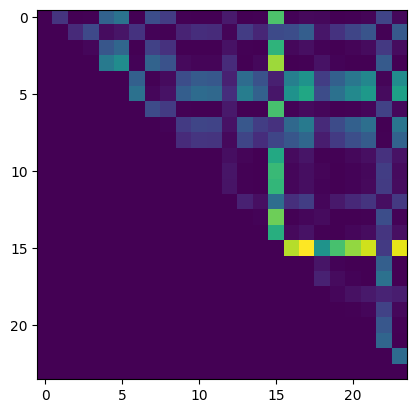

In [199]:
plt.imshow(res_arr, cmap="viridis")

In [200]:
x,y = np.meshgrid(comparisons, comparisons)

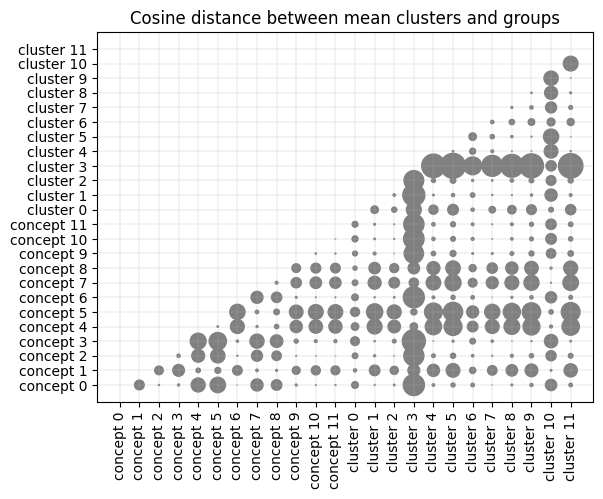

In [201]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 3000, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Cosine distance between mean clusters and groups")
plt.show()

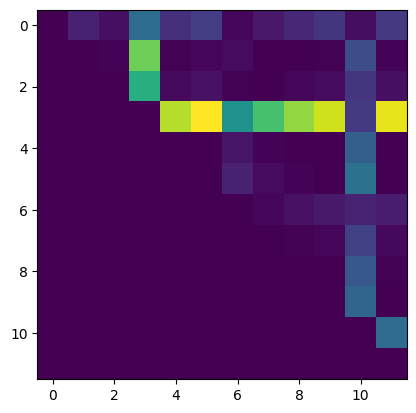

In [205]:
plt.imshow(res_arr[12:,12:], cmap="viridis")

In [206]:
points_concepts = res_arr[0:12, 0:12][res_arr[0:12, 0:12].nonzero()]
points_clusters = res_arr[12:, 12:][res_arr[12:, 12:].nonzero()]
points_inter = res_arr[0:12, 12:][res_arr[0:12, 12:].nonzero()]

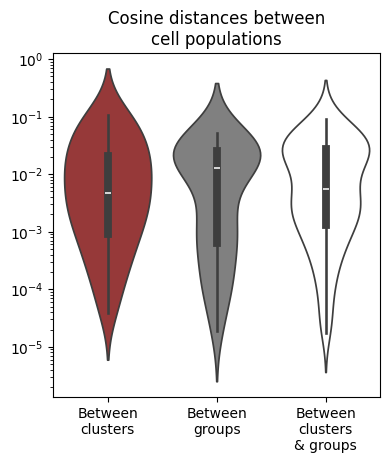

In [214]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), sharey=True)

data = [points_clusters, points_concepts, points_inter]
# print(data)

sns.violinplot(data=data, ax=ax, palette=["brown","gray","white"], log_scale=True)
plt.tight_layout()

# parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=False)
# for pc in parts['bodies']:
#     pc.set_facecolor('gray')
#     pc.set_edgecolor('black')
# parts['cmedians'].set_colors("k")

ax.set_title('Cosine distances between\ncell populations')
labels = ["Between\nclusters","Between\ngroups","Between\nclusters\n& groups"]
ax.set_xticks(np.arange(0, len(labels)), labels=labels)

# ax.set_yscale('log')
plt.show()

now do diff expression

In [74]:
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0, val0 = comparisons[i].split(" ")
        key1, val1 = comparisons[j].split(" ")
        val0, val1 = int(val0), int(val1)
        if key0 == key1 and val0 == val1:
            res_arr[i,j] = 0
        if (key0, val0, key1, val1) in res_dict_diffexp.keys():
            res = res_dict_diffexp[(key0, val0, key1, val1)]
            res_arr[i,j] = res[2]

(24, 24)


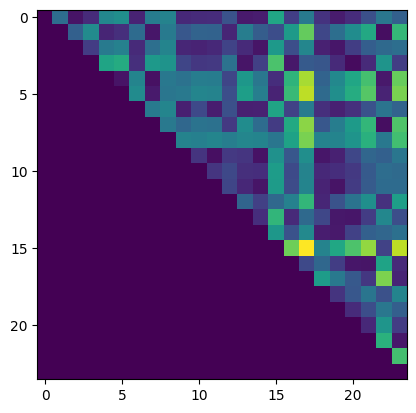

In [75]:
plt.imshow(res_arr, cmap="viridis")

In [76]:
x,y = np.meshgrid(comparisons, comparisons)

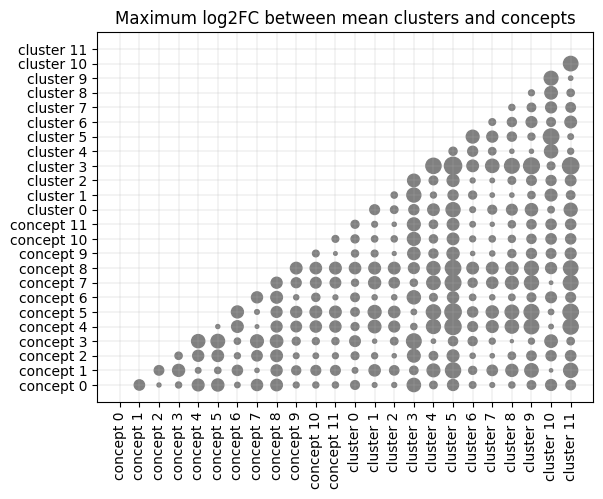

In [77]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 30, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Maximum log2FC between mean clusters and groups")
plt.show()

In [78]:
de_points = list(res_dict_diffexp.values())
top_ids = [el[0] for el in de_points]
top_ids = list(set(top_ids))
[all_feats[i] for i in top_ids]

['BETA_CATENIN', 'CK7', 'P21', 'PHISTONEH3', 'PHOSPHOTYROSINE', 'AREA_CELL']

## Now we repeat this form of analysis with salient cells

In [79]:
EPS = 1e-6
def diff_exp_stable(X0, X1):
    mu0 = X0.mean(axis=0)    
    mu1 = X1.mean(axis=0)
    fc = np.log2((mu1 + EPS) / (mu0 + EPS))
    pval = stats.ttest_ind(X1, X0)[1]
    pval_adj = pval * len(pval)
    pval_sig = pval_adj < 0.01
    res = [(i, fc[i], np.abs(fc[i]), pval_sig[i]) for i in range(len(fc)) if pval_sig[i] == True]
    res.sort(key=lambda x: x[2], reverse=True)
    if len(res) == 0:
        print("No significant differences found")
        return np.nan
    return res[0]

def cos_dist(X0, X1):
    mu0 = X0.mean(axis=0)    
    mu1 = X1.mean(axis=0)
    return distance.cosine(mu0, mu1)

In [87]:
def compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode="diff_exp"):
    if key0_a == "cluster":
        search_key0_a = "exp_cluster"
    else:
        search_key0_a = key0_a
    if key1 == "cluster":
        search_key1_a = "exp_cluster"
    else:
        search_key1_a = key1_a
    if key0_b == "cluster":
        search_key0_b = "exp_cluster"
    else:
        search_key0_b = key0_b
    if key1_b == "cluster":
        search_key1_b = "exp_cluster"
    else:
        search_key1_b = key1_b
    
    subset0 = filter_data_2conds(search_key0_a, val0_a, search_key0_b, val0_b, df)
    subset1 = filter_data_2conds(search_key1_a, val1_a, search_key1_b, val1_b, df)
    
    X0 = subset0.loc[:, "raw"]
    X0 = X0.apply(lambda x: parse_df_list(x))
    try:
        X0 = np.vstack(list(X0.values))
    except ValueError:
        if len(X0) == 0:
            print("no subset retrieved for X0")
            return np.nan
        else:
            print("unexpected error")
            return np.nan
    
    X1 = subset1.loc[:, "raw"]
    X1 = X1.apply(lambda x: parse_df_list(x))
    try:
        X1 = np.vstack(list(X1.values))
    except ValueError:
        if len(X1) == 0:
            print("no subset retrieved for X1")
            return np.nan
        else:
            print("unexpected error")
            return np.nan
    
    if mode == "diff_exp":
        res = diff_exp_stable(X0, X1)
    elif mode == "cos_dist":
        res = cos_dist(X0, X1)
    return res

In [85]:
def difference_runner_sal(df, mode="diff_exp"):
    res_dict = {}
    
    # same concept, change salience (9)
    for i in range(12):
        key0_a, key0_b = "concept", "salbin"
        val0_a, val0_b = i, "non-salient"
        key1_a, key1_b = "concept", "salbin"
        val1_a, val1_b = i, "salient"
        print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
        res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
        res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
        
    # change concept, keep salient (36)
    visited = {}
    for i in range(12):
        for j in range(12):
            if i == j:
                continue
            if (i,j) in visited.keys():
                continue
            if (j,i) in visited.keys():
                continue
            visited[(i,j)] = 1
            visited[(j,i)] = 1
            key0_a, key0_b = "concept", "salbin"
            val0_a, val0_b = i, "salient"
            key1_a, key1_b = "concept", "salbin"
            val1_a, val1_b = j, "salient"
            print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
            res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
            res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
            
    # change concept, keep non-salient (36)
    visited = {}
    for i in range(12):
        for j in range(12):
            if i == j:
                continue
            if (i,j) in visited.keys():
                continue
            if (j,i) in visited.keys():
                continue
            visited[(i,j)] = 1
            visited[(j,i)] = 1
            key0_a, key0_b = "concept", "salbin"
            val0_a, val0_b = i, "non-salient"
            key1_a, key1_b = "concept", "salbin"
            val1_a, val1_b = j, "non-salient"
            print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
            res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
            res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
    
    # same cluster, change salience (9)
    for i in range(12):
        key0_a, key0_b = "cluster", "salbin"
        val0_a, val0_b = i, "non-salient"
        key1_a, key1_b = "cluster", "salbin"
        val1_a, val1_b = i, "salient"
        print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
        res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
        res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
        
    # change cluster, keep salient (36)
    visited = {}
    for i in range(12):
        for j in range(12):
            if i == j:
                continue
            if (i,j) in visited.keys():
                continue
            if (j,i) in visited.keys():
                continue
            visited[(i,j)] = 1
            visited[(j,i)] = 1
            key0_a, key0_b = "cluster", "salbin"
            val0_a, val0_b = i, "salient"
            key1_a, key1_b = "cluster", "salbin"
            val1_a, val1_b = j, "salient"
            print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
            res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
            res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
            
    # change cluster, keep non-salient (36)
    visited = {}
    for i in range(12):
        for j in range(12):
            if i == j:
                continue
            if (i,j) in visited.keys():
                continue
            if (j,i) in visited.keys():
                continue
            visited[(i,j)] = 1
            visited[(j,i)] = 1
            key0_a, key0_b = "cluster", "salbin"
            val0_a, val0_b = i, "non-salient"
            key1_a, key1_b = "cluster", "salbin"
            val1_a, val1_b = j, "non-salient"
            print(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)
            res = compute_differences_2conds(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b, df, mode=mode)
            res_dict[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)] = res
            
    return res_dict
    

In [86]:
res_dict_diffexp_sal = difference_runner_sal(dfGs_all, mode="diff_exp")

concept 0 salbin non-salient concept 0 salbin salient
concept 1 salbin non-salient concept 1 salbin salient
concept 2 salbin non-salient concept 2 salbin salient
concept 3 salbin non-salient concept 3 salbin salient
concept 4 salbin non-salient concept 4 salbin salient
concept 5 salbin non-salient concept 5 salbin salient
concept 6 salbin non-salient concept 6 salbin salient
concept 7 salbin non-salient concept 7 salbin salient
concept 8 salbin non-salient concept 8 salbin salient
concept 9 salbin non-salient concept 9 salbin salient
concept 10 salbin non-salient concept 10 salbin salient
concept 11 salbin non-salient concept 11 salbin salient
concept 0 salbin salient concept 1 salbin salient
concept 0 salbin salient concept 2 salbin salient
concept 0 salbin salient concept 3 salbin salient
concept 0 salbin salient concept 4 salbin salient
concept 0 salbin salient concept 5 salbin salient
concept 0 salbin salient concept 6 salbin salient
concept 0 salbin salient concept 7 salbin salien

In [88]:
res_dict_diffexp_sal.keys()

dict_keys([('concept', 0, 'salbin', 'non-salient', 'concept', 0, 'salbin', 'salient'), ('concept', 1, 'salbin', 'non-salient', 'concept', 1, 'salbin', 'salient'), ('concept', 2, 'salbin', 'non-salient', 'concept', 2, 'salbin', 'salient'), ('concept', 3, 'salbin', 'non-salient', 'concept', 3, 'salbin', 'salient'), ('concept', 4, 'salbin', 'non-salient', 'concept', 4, 'salbin', 'salient'), ('concept', 5, 'salbin', 'non-salient', 'concept', 5, 'salbin', 'salient'), ('concept', 6, 'salbin', 'non-salient', 'concept', 6, 'salbin', 'salient'), ('concept', 7, 'salbin', 'non-salient', 'concept', 7, 'salbin', 'salient'), ('concept', 8, 'salbin', 'non-salient', 'concept', 8, 'salbin', 'salient'), ('concept', 9, 'salbin', 'non-salient', 'concept', 9, 'salbin', 'salient'), ('concept', 10, 'salbin', 'non-salient', 'concept', 10, 'salbin', 'salient'), ('concept', 11, 'salbin', 'non-salient', 'concept', 11, 'salbin', 'salient'), ('concept', 0, 'salbin', 'salient', 'concept', 1, 'salbin', 'salient'), (

In [89]:
res_save_path = "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/res_dict_de_sal.obj"
serialize(res_dict_diffexp_sal, res_save_path)

In [90]:
res_dict_diffexp_sal = deserialize(res_save_path)

In [91]:
comparisons = []
for el in ["salient", "non-salient"]:
    for i in range(12):
        comparisons.append(el + " " + str(i))

In [92]:
len(res_dict_diffexp_sal.keys())

288

In [93]:
res_dict_diffexp_sal.values()

dict_values([(29, -1.3734484006120542, 1.3734484006120542, True), (29, 2.1626190596158663, 2.1626190596158663, True), (22, -0.1959945004348016, 0.1959945004348016, True), (29, -3.6517721401089838, 3.6517721401089838, True), (29, 3.3076059757516942, 3.3076059757516942, True), (29, 4.628977953312362, 4.628977953312362, True), (29, -0.6772827924657872, 0.6772827924657872, True), (29, 2.151302533915567, 2.151302533915567, True), (29, 2.6466381792835283, 2.6466381792835283, True), (29, 1.6853088860223497, 1.6853088860223497, True), (29, -1.8395639118926204, 1.8395639118926204, True), (29, 1.7885160620572813, 1.7885160620572813, True), (29, 0.4073532360535905, 0.4073532360535905, True), (29, -0.25994613819600476, 0.25994613819600476, True), (29, -2.9506814199694205, 2.9506814199694205, True), (29, 1.0164249429661192, 1.0164249429661192, True), (29, 2.167293775016506, 2.167293775016506, True), (29, -0.6678332136823119, 0.6678332136823119, True), (22, 0.18890625742308392, 0.18890625742308392, 

In [94]:
N = len(comparisons)
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0_a, key0_b = "concept", "salbin"
        val0_b, val0_a = comparisons[i].split(" ")
        key1_a, key1_b = "concept", "salbin"
        val1_b, val1_a = comparisons[j].split(" ")
        val0_a, val1_a = int(val0_a), int(val1_a)
        
        if key0_a == key1_a and val0_a == val1_a:
            res_arr[i,j] = 0
        if key0_b == key1_b and val0_b == val1_b:
            res_arr[i,j] = 0
        if (key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b) in res_dict_diffexp_sal.keys():
            res = res_dict_diffexp_sal[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)]
            if (res is not np.nan) and (type(res) == tuple):
                print(res)
                res_arr[i,j] = res[2]
            else:
                print("NaN reached")

(24, 24)
(29, 0.4073532360535905, 0.4073532360535905, True)
(29, -0.25994613819600476, 0.25994613819600476, True)
(29, -2.9506814199694205, 2.9506814199694205, True)
(29, 1.0164249429661192, 1.0164249429661192, True)
(29, 2.167293775016506, 2.167293775016506, True)
(29, -0.6678332136823119, 0.6678332136823119, True)
(22, 0.18890625742308392, 0.18890625742308392, True)
(29, 0.7168926431145684, 0.7168926431145684, True)
(29, 1.3059813694109355, 1.3059813694109355, True)
(29, -1.9813091181100713, 1.9813091181100713, True)
(29, 1.6311137955454236, 1.6311137955454236, True)
(29, 1.6593636414425528, 1.6593636414425528, True)
(29, -1.031371640330863, 1.031371640330863, True)
(29, 2.9357347226046766, 2.9357347226046766, True)
(29, 4.086603554655063, 4.086603554655063, True)
(29, 1.2514765659562455, 1.2514765659562455, True)
(29, 2.0050588785689327, 2.0050588785689327, True)
(29, 2.6362024227531258, 2.6362024227531258, True)
(29, 3.225291149049493, 3.225291149049493, True)
(6, -0.26074774440614

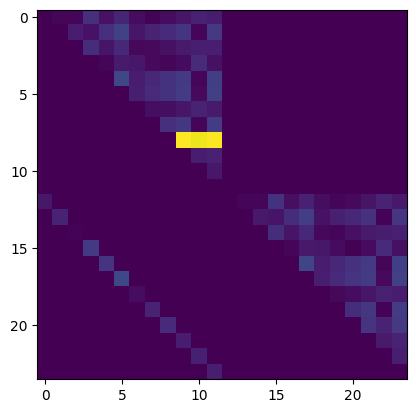

In [95]:
plt.imshow(res_arr, cmap="viridis")

In [96]:
x,y = np.meshgrid(comparisons, comparisons)

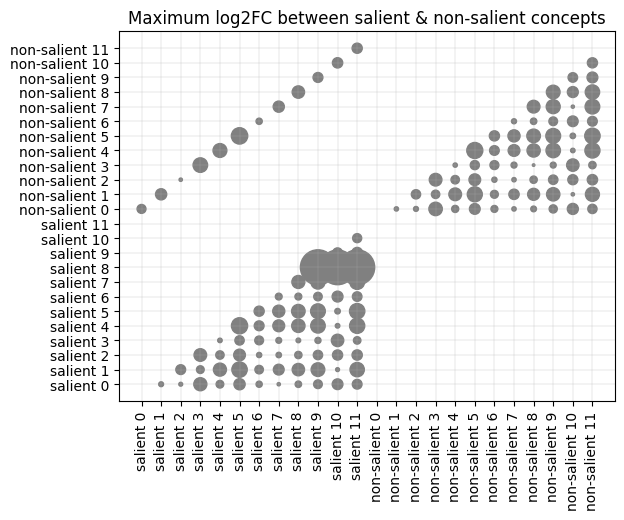

In [97]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 30, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Maximum log2FC between salient & non-salient concepts")
plt.show()

In [98]:
de_points = list(res_dict_diffexp_sal.values())
top_ids = [el[0] for el in de_points if type(el) == tuple]
top_ids = list(set(top_ids))
[all_feats[i] for i in top_ids]

['BETA_CATENIN',
 'BETA_TUBULIN',
 'CK7',
 'P21',
 'P4EBP1',
 'PHISTONEH3',
 'PHOSPHOTYROSINE',
 'AREA_CELL']

In [99]:
N = len(comparisons)
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0_a, key0_b = "cluster", "salbin"
        val0_b, val0_a = comparisons[i].split(" ")
        key1_a, key1_b = "cluster", "salbin"
        val1_b, val1_a = comparisons[j].split(" ")
        val0_a, val1_a = int(val0_a), int(val1_a)
        
        if key0_a == key1_a and val0_a == val1_a:
            res_arr[i,j] = 0
        if key0_b == key1_b and val0_b == val1_b:
            res_arr[i,j] = 0
        if (key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b) in res_dict_diffexp_sal.keys():
            res = res_dict_diffexp_sal[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)]
            if (res is not np.nan) and (type(res) == tuple):
                res_arr[i,j] = res[2]
            else:
                print("NaN reached")

(24, 24)


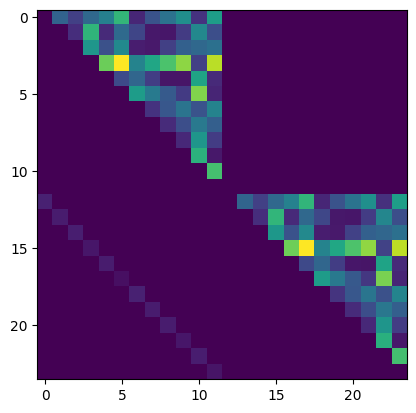

In [100]:
plt.imshow(res_arr, cmap="viridis")

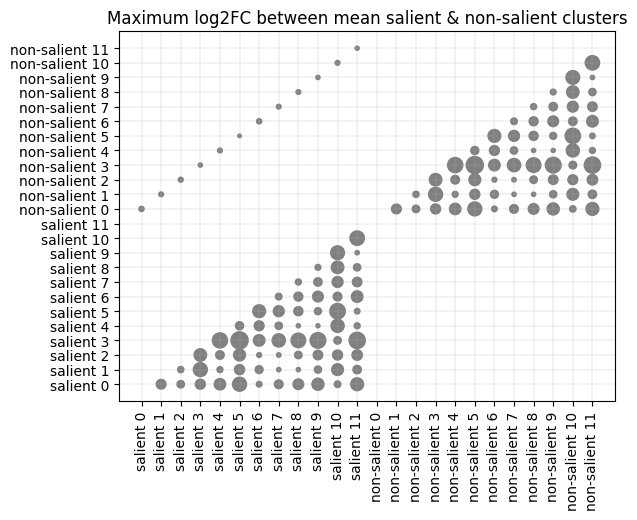

In [101]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 30, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Maximum log2FC between mean salient & non-salient clusters")
plt.show()

and now we do cosine

In [102]:
res_dict_cosine_sal = difference_runner_sal(dfGs_all, mode="cos_dist")

concept 0 salbin non-salient concept 0 salbin salient
concept 1 salbin non-salient concept 1 salbin salient
concept 2 salbin non-salient concept 2 salbin salient
concept 3 salbin non-salient concept 3 salbin salient
concept 4 salbin non-salient concept 4 salbin salient
concept 5 salbin non-salient concept 5 salbin salient
concept 6 salbin non-salient concept 6 salbin salient
concept 7 salbin non-salient concept 7 salbin salient
concept 8 salbin non-salient concept 8 salbin salient
concept 9 salbin non-salient concept 9 salbin salient
concept 10 salbin non-salient concept 10 salbin salient
concept 11 salbin non-salient concept 11 salbin salient
concept 0 salbin salient concept 1 salbin salient
concept 0 salbin salient concept 2 salbin salient
concept 0 salbin salient concept 3 salbin salient
concept 0 salbin salient concept 4 salbin salient
concept 0 salbin salient concept 5 salbin salient
concept 0 salbin salient concept 6 salbin salient
concept 0 salbin salient concept 7 salbin salien

In [115]:
res_save_path = "/scr/biggest/gmachi/datasets/celldive_lung/top_model_results_final/res_dict_cd_sal.obj"
serialize(res_dict_cosine_sal, res_save_path)

In [116]:
res_dict_cosine_sal = deserialize(res_save_path)

In [117]:
N = len(comparisons)
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0_a, key0_b = "concept", "salbin"
        val0_b, val0_a = comparisons[i].split(" ")
        key1_a, key1_b = "concept", "salbin"
        val1_b, val1_a = comparisons[j].split(" ")
        val0_a, val1_a = int(val0_a), int(val1_a)
        
        if key0_a == key1_a and val0_a == val1_a:
            res_arr[i,j] = 0
        if key0_b == key1_b and val0_b == val1_b:
            res_arr[i,j] = 0
        if (key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b) in res_dict_cosine_sal.keys():
            res = res_dict_cosine_sal[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)]
            if (res is not np.nan):
                res_arr[i,j] = res
            else:
                print("NaN reached")

(24, 24)


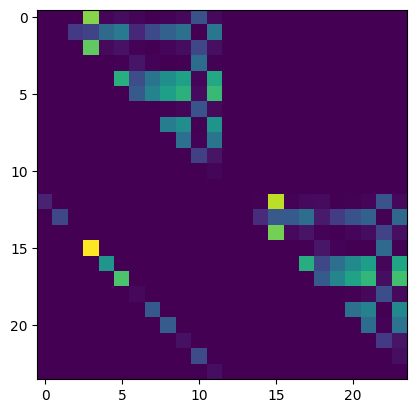

In [118]:
plt.imshow(res_arr, cmap="viridis")

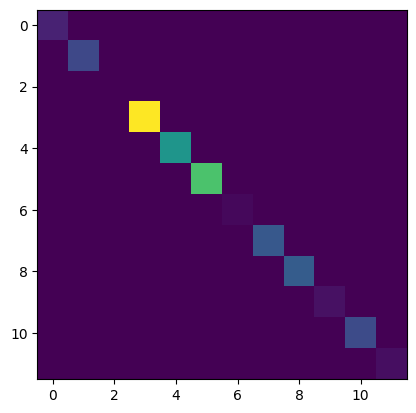

In [119]:
plt.imshow(res_arr[12:,0:12], cmap="viridis")

In [120]:
points_concepts = res_arr[12:, 0:12][res_arr[12:, 0:12].nonzero()]

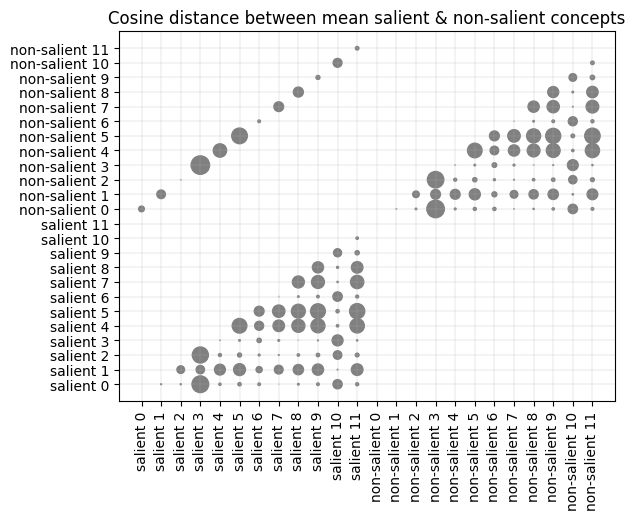

In [121]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 2000, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Cosine distance between mean salient & non-salient concepts")
plt.show()

In [122]:
N = len(comparisons)
res_arr = np.zeros((N,N))
print(res_arr.shape)
for i in range(N):
    for j in range(N):
        key0_a, key0_b = "cluster", "salbin"
        val0_b, val0_a = comparisons[i].split(" ")
        key1_a, key1_b = "cluster", "salbin"
        val1_b, val1_a = comparisons[j].split(" ")
        val0_a, val1_a = int(val0_a), int(val1_a)
        
        if key0_a == key1_a and val0_a == val1_a:
            res_arr[i,j] = 0
        if key0_b == key1_b and val0_b == val1_b:
            res_arr[i,j] = 0
        if (key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b) in res_dict_diffexp_sal.keys():
            res = res_dict_cosine_sal[(key0_a, val0_a, key0_b, val0_b, key1_a, val1_a, key1_b, val1_b)]
            if (res is not np.nan):
                res_arr[i,j] = res
            else:
                print("NaN reached")

(24, 24)


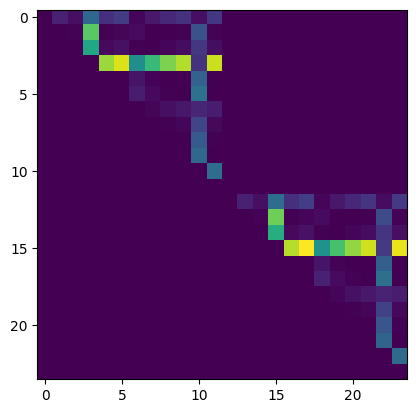

In [123]:
plt.imshow(res_arr, cmap="viridis")

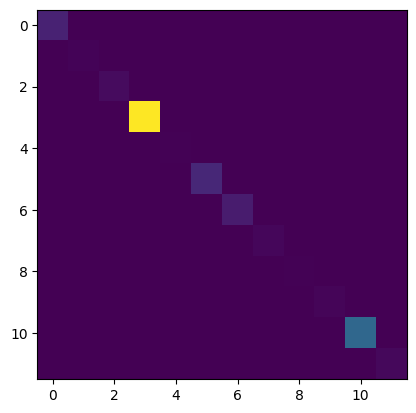

In [124]:
plt.imshow(res_arr[12:,0:12], cmap="viridis")

In [125]:
points_clusters = res_arr[12:, 0:12][res_arr[12:, 0:12].nonzero()]

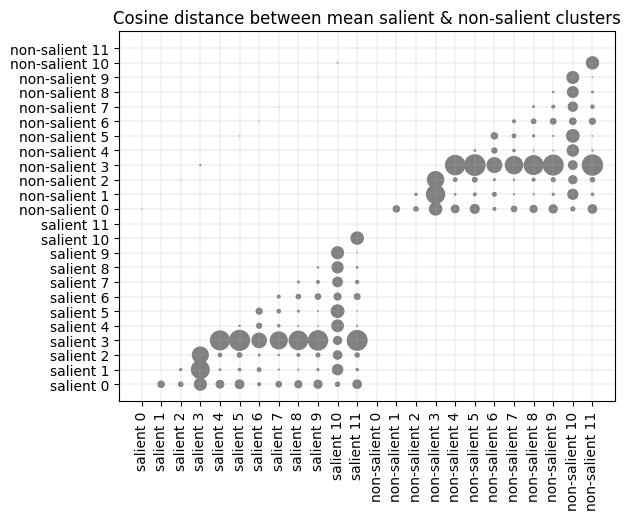

In [126]:
plt.figure()
plt.scatter(x=x.flatten(), y=y.flatten(), s=res_arr.flatten() * 2000, c="gray")
# plt.margins(.4)
plt.xticks(rotation=90)
    
plt.grid(linewidth=0.2)
plt.title("Cosine distance between mean salient & non-salient clusters")
plt.show()

### making this simpler by plotting the diagonals

In [127]:
import seaborn as sns

In [128]:
import seaborn as sns
sns.__version__

'0.13.2'

[array([9.81852638e-03, 4.52693829e-03, 3.81062412e-02, 1.44260576e-02,
       1.95778396e-02, 1.73425588e-03, 7.24594170e-03, 1.22366823e-02,
       1.62802115e-02, 3.79880983e-03, 1.79475482e-02, 1.02125452e-03,
       8.33970779e-02, 4.49088338e-04, 1.69220150e-03, 3.32336383e-03,
       1.97186907e-04, 1.34918828e-04, 8.26412711e-04, 2.53389324e-02,
       1.23688820e-03, 6.69403755e-02, 2.82049818e-03, 5.33365383e-03,
       6.61540421e-04, 3.21181439e-04, 1.89712777e-03, 3.67819024e-03,
       1.63391148e-02, 4.49728607e-03, 9.51054384e-02, 1.07087815e-01,
       5.49298054e-02, 7.59727889e-02, 8.97444877e-02, 9.94561118e-02,
       1.81399832e-02, 1.03277156e-01, 4.00688454e-04, 6.20269242e-03,
       1.24042768e-03, 9.17899431e-05, 5.71551211e-05, 3.23364467e-02,
       1.95698847e-04, 9.73204661e-03, 3.04213280e-03, 8.72903192e-04,
       1.56999979e-04, 3.97751810e-02, 3.82223705e-05, 1.90354180e-03,
       4.79240645e-03, 7.44396601e-03, 1.05071216e-02, 8.58960293e-03,
     

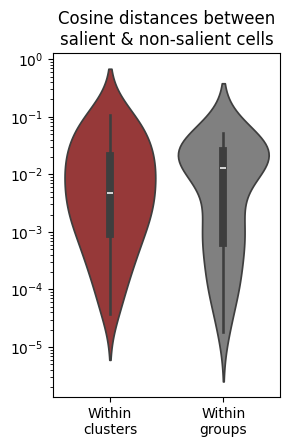

In [216]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 4), sharey=True)

data = [points_clusters, points_concepts]
print(data)

sns.violinplot(data=data, ax=ax, palette=["brown","gray"], log_scale=True)
plt.tight_layout()

# parts = ax.violinplot(data, showmeans=False, showmedians=True, showextrema=False)
# for pc in parts['bodies']:
#     pc.set_facecolor('gray')
#     pc.set_edgecolor('black')
# parts['cmedians'].set_colors("k")

ax.set_title('Cosine distances between\nsalient & non-salient cells')
labels = ["Within\nclusters","Within\ngroups"]
ax.set_xticks(np.arange(0, len(labels)), labels=labels)


# ax.set_yscale('log')
plt.show()

## finally, get ridgelines for salient cells

In [22]:
# feat_subset = ['BETA_TUBULIN','CK5','CK7','P21','PANKERATIN','PHISTONEH3','AREA_CELL','MAJORAXISLENGTH']

In [47]:
def plot_ridgeline_sal(key_a, value_a, key_b, value_b, df, feat_names, feat2idx_dict=None):
    if key_a == "cluster":
        search_key_a = "exp_cluster"
    else:
        search_key_a = key_a
    if key_b == "cluster":
        search_key_b = "exp_cluster"
    else:
        search_key_b = key_b
    
    if len(feat_names) < 34 and feat2idx_dict is not None:
        idxs = [feat2idx_dict[feat] for feat in feat_names]
        
    X_all = df.loc[:, "raw"]
    X_all = X_all.apply(lambda x: parse_df_list(x))
    X_all = np.vstack(list(X_all.values))
    scaler = MinMaxScaler()
    scaler.fit(X_all)
    
    subset = filter_data_2conds(search_key_a, value_a, search_key_b, value_b, df)
    X = subset.loc[:, "raw"]
    X = X.apply(lambda x: parse_df_list(x))
    try:
        X = np.vstack(list(X.values))
    except ValueError:
        if len(X) == 0:
            print("no subset retrieved for X")
            return
        else:
            print("unexpected error")
            return
    X = scaler.transform(X)
    p = X.shape[1]
    
    plt.figure()
    if len(feat_names) < 34 and feat2idx_dict is not None:
        print("Note: only using a subset of features as requested...")
        X = X[:, idxs]
        p = X.shape[1]
        fig, ax = plt.subplots(figsize=(2, 4))
        w = 1.5
    else: 
        fig, ax = plt.subplots(figsize=(3, 12))
        w = 1
    
    ax.yaxis.grid(True, linestyle='-')        
    
    parts = ax.violinplot(X, positions=np.arange(p), widths=w, vert=False, showmeans=True, showmedians=False, showextrema=False, side="high")
    
    if key_a == "concept":
        c = joint_cmap(value_a)
    else:
        c = "brown"
        
    for pc in parts['bodies']:
        pc.set_facecolor(c)
        # pc.set_edgecolor('black')
        pc.set_alpha(0.8)
    parts['cmeans'].set_colors("k")
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title("Salient " + key_a + " " + str(value_a))
    #'Rescaled marker\ndistributions for ' +
    ax.set_yticks(np.arange(p), feat_names, rotation=0)
    ax.set_xlim(-0.05, 1.05)
    plt.show()
    
    return

In [48]:
# plot_ridgeline("concept", 0, dfGs_all, all_feats, feat2idx_dict=None, cond_count=2)
# plot_ridgeline_sal("concept", 0, "salbin", "salient", dfGs_all, all_feats, feat2idx_dict=None)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

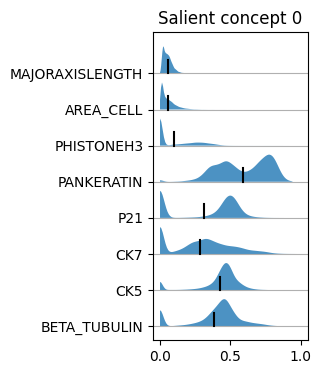

In [49]:
# plot_ridgeline("concept", 0, dfGs_all, feat_subset, feat2idx_dict, cond_count=2)
plot_ridgeline_sal("concept", 0, "salbin", "salient", dfGs_all, feat_subset, feat2idx_dict=feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

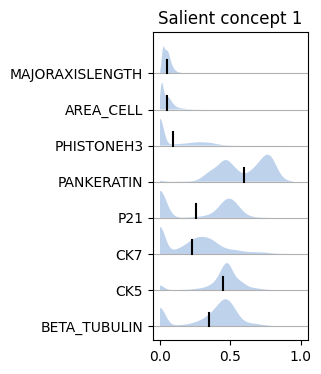

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

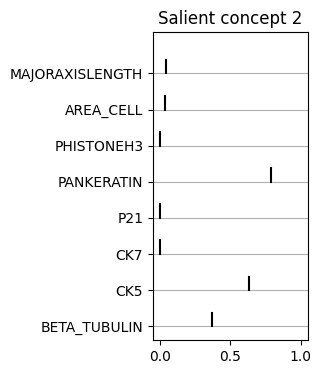

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

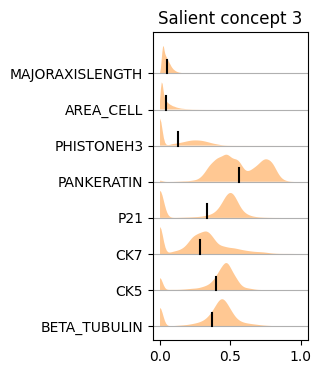

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

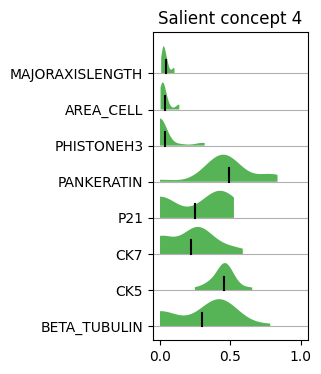

no subset retrieved for X
Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

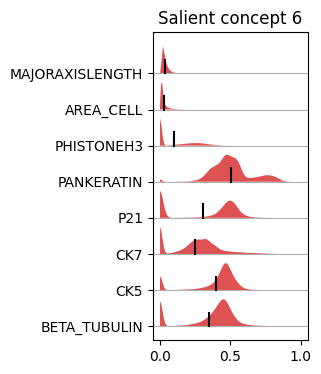

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

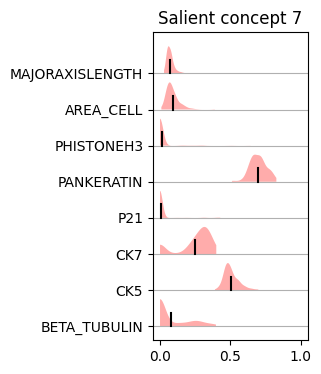

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

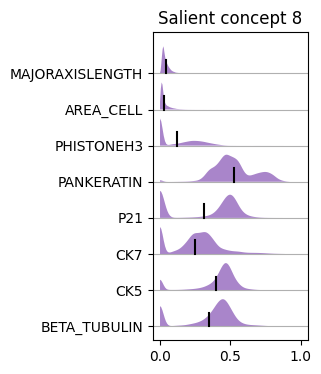

In [50]:
for i in range(1,9):
    plot_ridgeline_sal("concept", i, "salbin", "salient", dfGs_all, feat_subset, feat2idx_dict=feat2idx_dict)

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

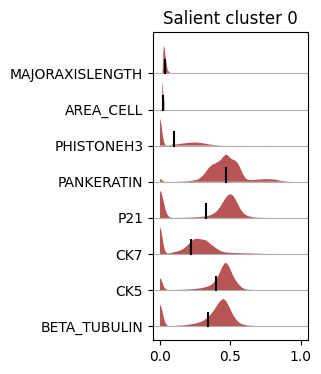

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

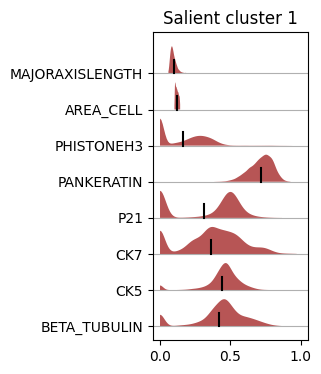

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

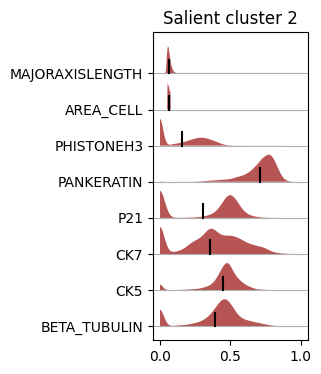

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

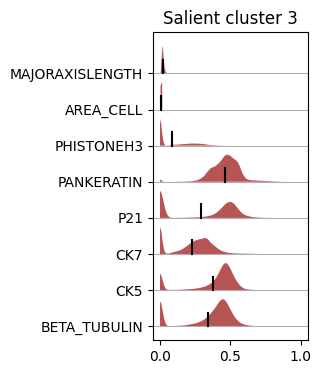

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

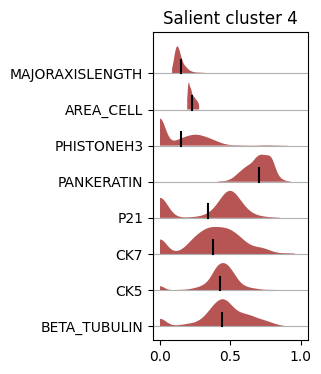

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

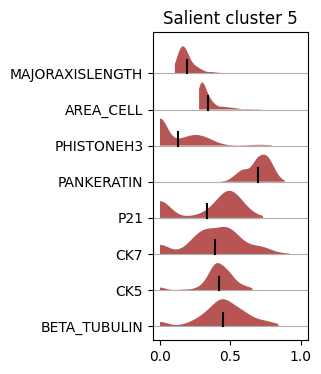

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

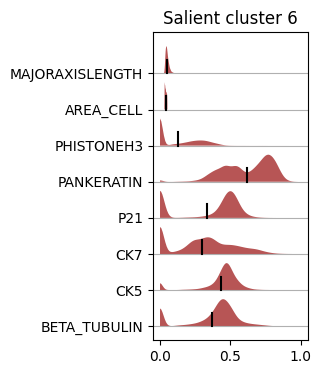

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

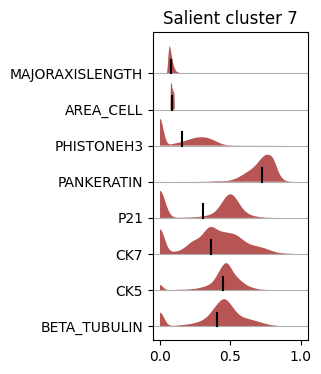

Note: only using a subset of features as requested...


<Figure size 640x480 with 0 Axes>

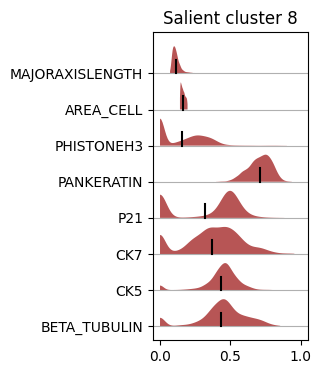

In [52]:
for i in range(9):
    plot_ridgeline_sal("cluster", i, "salbin", "salient", dfGs_all, feat_subset, feat2idx_dict=feat2idx_dict)